<h2>Lab7b: Loading your own dataset with Scikit-learn and MNIST dataset</h2>

Read the lab tutorial Lab7a http://www.via.cornell.edu/courses/ece547/lab/lab7/lab7a.html first as it contains useful tools for lab7.

Reference: http://scikit-learn.org/stable/auto_examples/linear_model/plot_sparse_logistic_regression_mnist.html

Reference: http://scikit-learn.org/stable/auto_examples/neural_networks/plot_mnist_filters.html

This tutorial informs on how to load your own images for use with scikit-learn on the MNIST dataset

In [1]:
#1 import required modules
import time
import io
import matplotlib.pyplot as plt
import numpy as np
from scipy.io.arff import loadarff

from sklearn.datasets import get_data_home
from joblib import Memory
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
from urllib.request import urlopen 

In [2]:
#2.  read the NMIST dataset
memory = Memory(get_data_home())
@memory.cache()
def fetch_mnist():
    content = urlopen(
        'https://www.openml.org/data/download/52667/mnist_784.arff').read()
    data, meta = loadarff(io.StringIO(content.decode('utf8')))
    data = data.view([('pixels', '<f8', 784), ('class', '|S1')])
    return data['pixels'], data['class']
X, y = fetch_mnist()

Note: the labels are converted to integers for this example (for both training and new test datasets)

In [3]:
# rescale the data, use the traditional train/test split

X = X / 255.

###### NEW  Refromat the the labels to be string rather than byte arrays
y_trans = []
for i in range(len(y)):
    y_trans.append(y[i].decode("utf-8"))
y = np.asarray(y_trans)

X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]


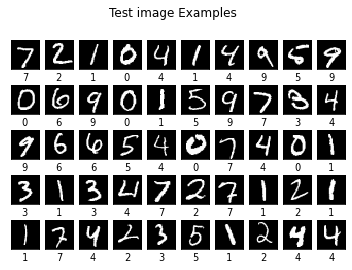

In [4]:
### Bounus 1: show the first 40 images
### ALways a good idea to validate that the data appears as you expect
### 
### for sci-kit learn the images are represented as vectors of 784 elements
### currently scaled from 0 to 1

for i in range(50):
    l1_plot = plt.subplot(5, 10, i + 1)
    l1_plot.imshow(255 * X_test[i].reshape(28, 28), interpolation='nearest',
                   cmap=plt.cm.gray)
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    #l1_plot.set_xlabel('Class %s' % y_test[i].decode())
    l1_plot.set_xlabel('%s' % str(y_test[i]))
plt.suptitle('Test image Examples')
plt.show()

In [5]:
## Data standardization
## by the mean and standared deviation of the training set
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
#train and test classifier
# Turn up tolerance for faster convergence
clf = LogisticRegression(C=50. / 1000,
                         multi_class='multinomial',
                         penalty='l1', solver='saga', tol=0.1)
# Train the classifier
clf.fit(X_train, y_train)

#Evaluate the classifier
sparsity = np.mean(clf.coef_ == 0) * 100
score = clf.score(X_test, y_test)
y_pred = clf.predict(X)

# print('Best C % .4f' % clf.C_)
print("Sparsity with L1 penalty: %.2f%%" % sparsity)
print("Test score with L1 penalty: %.4f" % score)
print("y_predicted_values", y_pred)
print("y_labels", y)

Sparsity with L1 penalty: 16.72%
Test score with L1 penalty: 0.8926
y_predicted_values ['8' '8' '2' '1' '2' '2' '2' '2' '2' '2' '7' '3' '3' '0' '0' '1' '4' '4'
 '4' '1' '5' '3' '4' '5' '5' '6' '6' '5' '6' '0' '7' '4' '7' '7' '7' '8'
 '3' '5' '2' '4' '9' '7' '9' '4' '7' '0' '0' '5' '0' '5' '4' '0' '5' '0'
 '5' '4' '4' '5' '7' '3']
y_labels ['1' '1' '1' '1' '1' '2' '2' '2' '2' '2' '3' '3' '3' '3' '3' '4' '4' '4'
 '4' '4' '5' '5' '5' '5' '5' '6' '6' '6' '6' '6' '7' '7' '7' '7' '7' '8'
 '8' '8' '8' '8' '9' '9' '9' '9' '9' '0' '0' '0' '0' '0' 'X' 'X' 'X' 'X'
 'X' 'X' 'X' 'X' 'X' 'X']


# Dataset loading program for your own data
To test or train a scikit-learn network you need to create an image database which can be done as follows:

1. Create a directory to hold your database, in the example below this is called 'idata'.
2. Convert all images to .png format and store them in this directory.
3. Create a .csv text file in this directory in which each row contains the name of an image and its label value separated by a comma. In the example below the file is named 'labels.csv' and its contents are:

tst0.png,7<br>
tst1.png,2<br>
tst2.png,1<br>
tst3.png,0<br>

There are also 4 images in idata with names tst0.png through tst3.png

<h2>The following code may then be used read the database into scikit-learn:</h2>

In [7]:
""" Custom datatset loader
    based on https://github.com/utkuozbulak/pytorch-custom-dataset-examples
"""
import pandas as pd
import imageio

class SimpleDataset():
    def __init__(self, data_path, csv_name, transform = None ):
        """
        Args:
            data_path (string): path to the folder where images and csv files are located
            csv_name (string): name of the csv lablel file
            transform: pytorch transforms for transforms and tensor conversion
        """
        # Set path
        self.data_path = data_path
        # Read the csv file
        self.data_info = pd.read_csv(data_path + csv_name, header=None)
        # First column contains the image paths
        self.image_arr = np.asarray(self.data_info.iloc[:, 0])
        # Second column is the labels
        self.label_arr = np.asarray(self.data_info.loc[:, 1])
        # Calculate len
        self.data_len = len(self.data_info.index)
        
    def __getitem__(self, index):
        # Get image name from the pandas df
        single_image_name = self.image_arr[index]
        # Open image
        img_as_img = imageio.imread(self.data_path + single_image_name)
        
        # Get label(class) of the image based on the cropped pandas column
        single_image_label = self.label_arr[index]
        
        return (img_as_img, single_image_label)

    def __len__(self):
        return self.data_len

## Reading and formatting your data

In [8]:
mydata = SimpleDataset( "./idata/", "labels.csv")

#splitting into images and labels 
X = []
y = []
for i in range(len(mydata)):
    X.append(mydata[i][0])
    y.append((mydata[i][1]))

#converting into numpy arrays to enable easy reshaping and other array operations
    
X = np.asarray(X)
print("Shape of the input image", X.shape)
y= np.asarray(y)

Shape of the input image (60, 28, 28)


## Displaying the new  test images 
The images are currently in the format (28, 28). But for model testing, they are converting into (784, ) shape array to maintain consistency with the shape of X_train dataset.


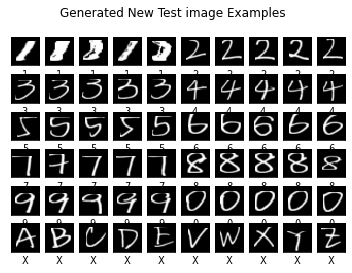

In [9]:
import warnings
warnings.filterwarnings('ignore')
for i in range(60):
    l1_plot = plt.subplot(6, 10, i + 1)
    l1_plot.imshow(X[i], interpolation='nearest',
                   cmap=plt.cm.gray)
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel('%s' % (y[i]))
plt.suptitle('Generated New Test image Examples')
plt.show()

## Testing the trained classifier with the new dataset

Predict class labels for samples in X.

In [10]:
#reshaping the array into flattened 784 array as an input for prediciton by the logistic regression classifier
X = X.reshape(X.shape[0], 784)
X = X / 255.
#data standardiation with the training set statistics is required for this clasifier
X = scaler.transform(X)

y_pred = clf.predict(X)

score = clf.score(X, y)

print("Test score with L1 penalty: %.4f" % score)
print("y_predicted_values", y_pred)
print("y_labels", y)

Test score with L1 penalty: 0.4500
y_predicted_values ['8' '8' '2' '1' '2' '2' '2' '2' '2' '2' '7' '3' '3' '0' '0' '1' '4' '4'
 '4' '1' '5' '3' '4' '5' '5' '6' '6' '5' '6' '0' '7' '4' '7' '7' '7' '8'
 '3' '5' '2' '4' '9' '7' '9' '4' '7' '0' '0' '5' '0' '5' '4' '0' '5' '0'
 '5' '4' '4' '5' '7' '3']
y_labels ['1' '1' '1' '1' '1' '2' '2' '2' '2' '2' '3' '3' '3' '3' '3' '4' '4' '4'
 '4' '4' '5' '5' '5' '5' '5' '6' '6' '6' '6' '6' '7' '7' '7' '7' '7' '8'
 '8' '8' '8' '8' '9' '9' '9' '9' '9' '0' '0' '0' '0' '0' 'X' 'X' 'X' 'X'
 'X' 'X' 'X' 'X' 'X' 'X']
